In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import neuron_optimize_functions as h

### Dataset Loading, Visualize & Proprocessing

In [2]:
# Loading the data (cat/non-cat)
train_X_orig, train_Y, test_X_orig, test_Y, classes = h.load_dataset()

y = [1], it's a 'cat' picture.


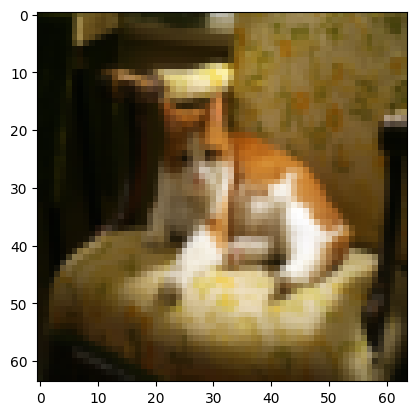

In [3]:
# Visualize sample picture
index = 7
plt.imshow(train_X_orig[index])
print ("y = " + str(train_Y[:, index]) + ", it's a '" + classes[np.squeeze(train_Y[:, index])].decode("utf-8") +  "' picture.")

In [4]:
m_train = train_X_orig.shape[0]
m_test = test_X_orig.shape[0]
num_px = train_X_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_X_orig shape: " + str(train_X_orig.shape))
print ("train_Y shape: " + str(train_Y.shape))
print ("test_X_orig shape: " + str(test_X_orig.shape))
print ("test_Y shape: " + str(test_Y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_X_orig shape: (209, 64, 64, 3)
train_Y shape: (1, 209)
test_X_orig shape: (50, 64, 64, 3)
test_Y shape: (1, 50)


In [5]:
# Reshape(flatten) and normalize the image data
train_X, test_X = h.preprocess_data(train_X_orig, test_X_orig)

print ("train_X shape: " + str(train_X.shape))
print ("train_Y shape: " + str(train_Y.shape))
print ("test_X shape: " + str(test_X.shape))
print ("test_Y shape: " + str(test_Y.shape))

train_X shape: (12288, 209)
train_Y shape: (1, 209)
test_X shape: (12288, 50)
test_Y shape: (1, 50)


### Epoch Function: Forward and Backward propagation

Forward Propagation:
- Input X
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Backward Propagation:
- Compute gardients <br>
$ dw = \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$ <br>
$ db = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$
- Update parameters <br>
$ w = w - \alpha \ dw$ <br>
$ b = b - \alpha \ db$

In [6]:
def epoch(X, Y, w, b, learning_rate=0.005):
    '''
    It uses vectorization of numpy and no for loop to go through all samples. 
    OPTIMIZED! 
    Performs one epoch(cycle) of training for neuron[logistic regression]
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1
    w : numpy.ndarray [shape: (#features, 1)]
        array containing weights used by neuron
    b : float
        bias used by neuron
    learning_rate : float (default=0.05)   

    Returns
    -------
    w : updated array of learned weights by neuron
    b : updated learned bias by neuron
    dw : array containing increments that were added to weights
    db : increment that was added to bias
    cost: average loss of samples with input parameters
    '''    
    m = X.shape[1]
    # FORWARD PROPAGATION (FROM X TO A)
    z = np.matmul(w.T,X)+b    # shape(1,m) --> (1,d)X(d,m)
    A = 1/(1+np.exp(-z))      # compute activation; shape(1,m)

    # BACKWARD PROPAGATION (FROM COST TO GRADs)
    cost = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))    # compute cost; shape()/scalar
    dz = A-Y    # shape(1,m)
    dw = 1/m*np.matmul(X,dz.T)    # shape(d,1) --> (d,m)X(m,1)
    db = 1/m*np.sum(dz)    # shape()/scalar

    # UPDATE PARAMETERS
    w = w - learning_rate*dw    # shape(d,1)
    b = b- learning_rate*db    # shape()/scalar
    
    return w, b, dw, db, cost

### Predict Function

The epoch function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X; implemented in the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [7]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    z = np.matmul(w.T,X)+b
    A = 1/(1+np.exp(-z))
    
    Y_prediction=(A >0.5).astype(int)
    
    return Y_prediction

### Model Function

In [8]:
def logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=0.005, print_cost=False, epoch_fun=epoch):
    """
    Single neuron flavoured logistic regression model that runs for num_epochs.
    
    Parameters
    ----------
    train_X : numpy.ndarray [shape: (#features, #samples)]
        matrix of training data
    train_Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1 for training data
    test_X : numpy.ndarray [shape: (#features, #samples)]
        matrix of testing data
    test_Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1 for testing data
    num_epochs : int (default=2000)
    learning_rate : float (default=0.005)
    print_cost : True/False (default=False)
        if True, it prints cost every 100 epochs and train accuracy
    epoch_fun : epoch function

    Returns
    -------
    d: dictionary {Y_prediction_train" : Y_prediction, costs, w, b,
         dw, db, learning_rate, num_epochs}
    """
    ## initialize parameters with zeros
    w = np.zeros((train_X.shape[0],1))
    b = 0.0

    ## epochs loop
    costs = []
    for i in range(num_epochs):
        # Cost and gradient calculation 
        w, b, dw, db, cost = epoch_fun(train_X, train_Y, w, b, learning_rate)
           
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training epochs
            if print_cost:
                print(f"Cost after epochs {i}, {cost}")
    
    ## Predict test/train set examples
    train_Y_prediction = predict(w,b,train_X)
    test_Y_prediction = predict(w,b,test_X)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(train_Y_prediction - train_Y)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(test_Y_prediction - test_Y)) * 100))

    
    d = { 
         "train_Y_prediction" : train_Y_prediction, "test_Y_prediction" : test_Y_prediction, 
         "costs": costs, "w" : w, "b" : b,
         "dw" : dw, "db" : db,
         "learning_rate" : learning_rate, "num_epochs": num_epochs}
    
    return d

### Run Model

In [9]:
neuron_model = logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=0.005, print_cost=True)

Cost after epochs 0, 0.6931471805599453
Cost after epochs 100, 0.5845083636993086
Cost after epochs 200, 0.46694904094655476
Cost after epochs 300, 0.37600686694802077
Cost after epochs 400, 0.3314632893282513
Cost after epochs 500, 0.30327306747438293
Cost after epochs 600, 0.2798795865826048
Cost after epochs 700, 0.26004213692587574
Cost after epochs 800, 0.24294068467796623
Cost after epochs 900, 0.22800422256726066
Cost after epochs 1000, 0.21481951378449635
Cost after epochs 1100, 0.20307819060644985
Cost after epochs 1200, 0.1925442771670686
Cost after epochs 1300, 0.18303333796883503
Cost after epochs 1400, 0.17439859438448876
Cost after epochs 1500, 0.16652139705400335
Cost after epochs 1600, 0.15930451829756614
Cost after epochs 1700, 0.15266732471296504
Cost after epochs 1800, 0.1465422350398234
Cost after epochs 1900, 0.14087207570310162
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Comment**: Training accuracy is close to 100%. This is a good sanity check: Test accuracy is 70%. The model is clearly overfitting the training data. It can be reduced by regularization technique and using more layers neural network to capture nonlinear complexity better.

y = 1, you predicted that it is a "cat" picture.


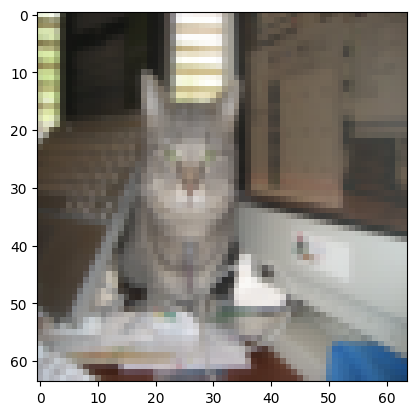

In [10]:
# Example of a picture that was wrongly classified.
index = 7
plt.imshow(test_X[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_Y[0,index]) + ", you predicted that it is a \"" + classes[int(neuron_model['test_Y_prediction'][0,index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

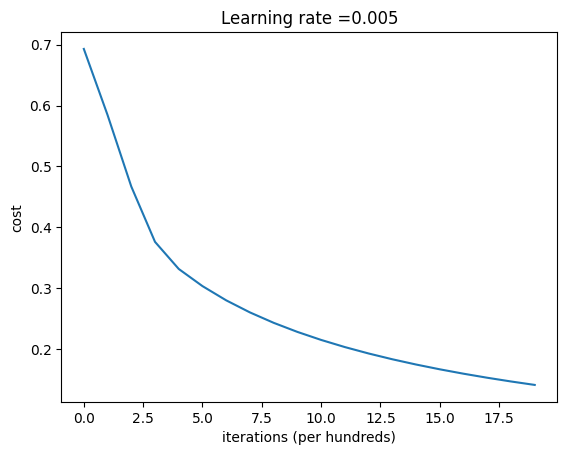

In [11]:
# Plot learning curve (with costs)
costs = np.squeeze(neuron_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(neuron_model["learning_rate"]))
plt.show()

**Interpretation**:
The cost decreasing shows that the parameters are being learned. However, could train the model even more on the training set. Increasing the number of iterations/epochs result in the training accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work, must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly change the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of `learning rates`. Run the cell below. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



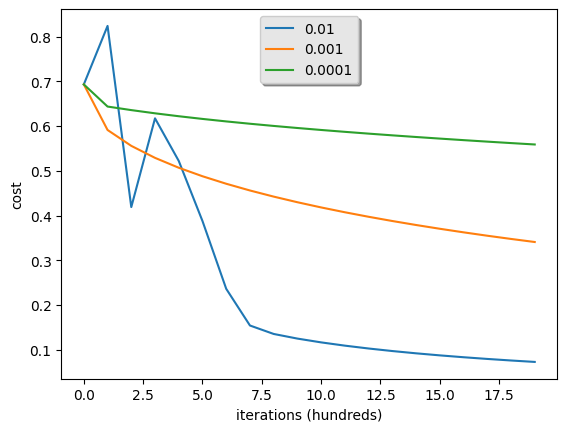

In [12]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If model overfits, use other techniques to reduce overfitting.


### Test with your own image ##

Use your own image and see the output of your model. To do that:
    1. Add image to this Jupyter Notebook's directory, in the "img" folder.
    2. Change your image's name in the following code
    3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

y = 0, neuron algorithm predicts a "non-cat" picture.


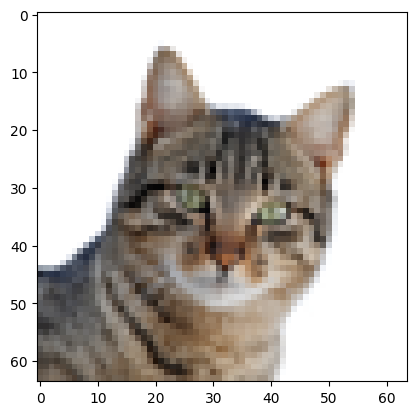

In [13]:
# change this to the name of your image file
my_image = "img/my_image_1.jpg"   

# We preprocess the image to fit your algorithm.
fname = "" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(neuron_model["w"], neuron_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", neuron algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 1, neuron algorithm predicts a "cat" picture.


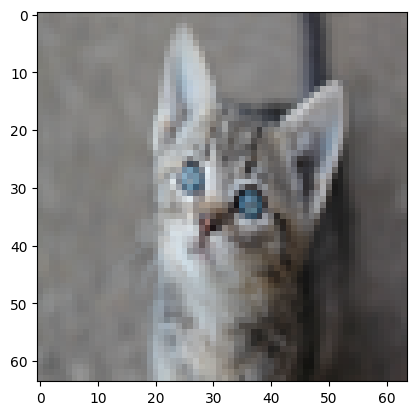

In [14]:
# change this to the name of your image file
my_image = "img/my_image_2.jpg"   

# We preprocess the image to fit your algorithm.
fname = "" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(neuron_model["w"], neuron_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", neuron algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")